# Decision Tree Classifier - Breast Cancer


In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets, tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import f1_score
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

import time

In [26]:
# General config of pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

cancer = datasets.load_breast_cancer()
print(f"Features: {cancer.feature_names}")
print("")
print(f"Target: {cancer.target_names}")

# Creating the dataset
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)

# 0: malignant (bad), 1: benign (Not bad)
df["target"] = cancer.target
df.sample(5)

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
473,12.27,29.97,77.42,465.4,0.07699,0.03398,0.00000,0.00000,0.1701,0.05960,...,38.05,85.08,558.9,0.09422,0.05213,0.00000,0.00000,0.2409,0.06743,1
450,11.87,21.54,76.83,432.0,0.06613,0.10640,0.08777,0.02386,0.1349,0.06612,...,28.18,83.51,507.2,0.09457,0.33990,0.32180,0.08750,0.2305,0.09952,1
189,12.30,15.90,78.83,463.7,0.08080,0.07253,0.03844,0.01654,0.1667,0.05474,...,19.59,86.65,546.7,0.10960,0.16500,0.14230,0.04815,0.2482,0.06306,1
37,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,1
481,13.90,19.24,88.73,602.9,0.07991,0.05326,0.02995,0.02070,0.1579,0.05594,...,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603,1


### Data Split

In [3]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (455, 30)
Test: (114, 30)


## Hyperparameter Tunning / Optuna

In [4]:
def objective(trial):
    n_estimators = trial.suggest_categorical("n_estimators", [30, 50, 100, 200])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int('max_depth', 4, 8, step=1)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
     # initializing the model
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   criterion=criterion,
                                   max_depth=max_depth,
                                   max_features=max_features,
                                   n_jobs=-1)
    # training
    model.fit(X_train, y_train)
    
    # prediction
    y_pred = model.predict(X_test)
    
    # evaluation
    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1  

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-06-07 06:43:58,588] A new study created in memory with name: no-name-3be75273-7265-4552-89ba-5fae7018b43f
[I 2024-06-07 06:43:58,979] Trial 0 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-06-07 06:43:59,270] Trial 1 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 50, 'criterion': 'log_loss', 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-06-07 06:44:00,240] Trial 2 finished with value: 0.965034965034965 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9722222222222222.
[I 2024-06-07 06:44:00,732] Trial 3 finished with value: 0.9722222222222222 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.9

In [6]:
# Study best trial
study.best_trial

FrozenTrial(number=84, state=TrialState.COMPLETE, values=[0.9793103448275862], datetime_start=datetime.datetime(2024, 6, 7, 6, 44, 28, 858957), datetime_complete=datetime.datetime(2024, 6, 7, 6, 44, 29, 7494), params={'n_estimators': 30, 'criterion': 'log_loss', 'max_depth': 7, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': CategoricalDistribution(choices=(30, 50, 100, 200)), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'max_depth': IntDistribution(high=8, log=False, low=4, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2'))}, trial_id=84, value=None)

In [7]:
# Best parameters
study.best_params

{'n_estimators': 30,
 'criterion': 'log_loss',
 'max_depth': 7,
 'max_features': 'log2'}

### Optuna Visulization

https://optuna.readthedocs.io/en/stable/reference/visualization/index.html

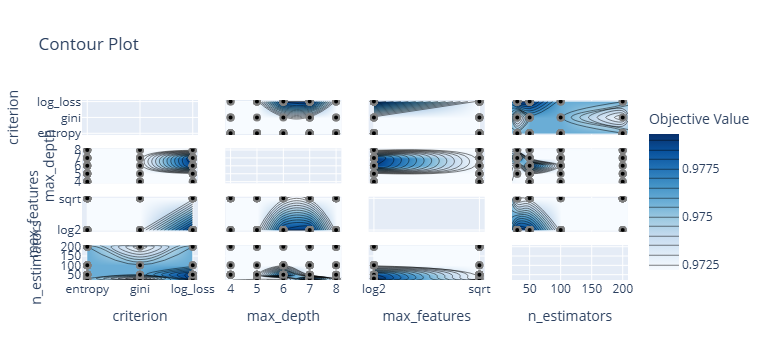

In [27]:
fig = optuna.visualization.plot_contour(study)
fig.show()

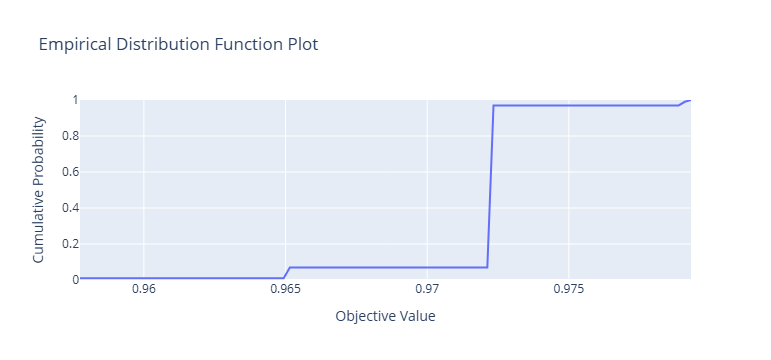

In [9]:
fig = optuna.visualization.plot_edf([study])
fig.show()

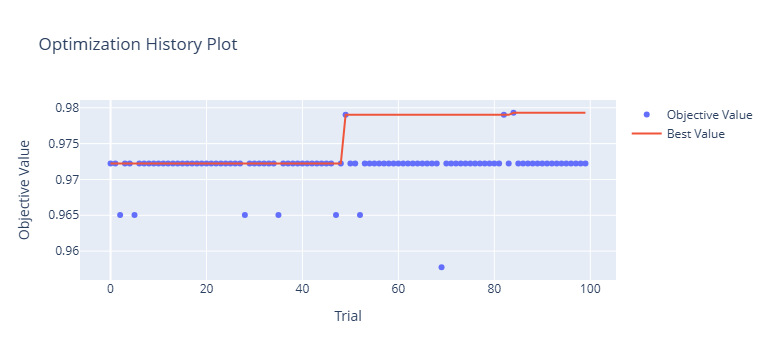

In [10]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

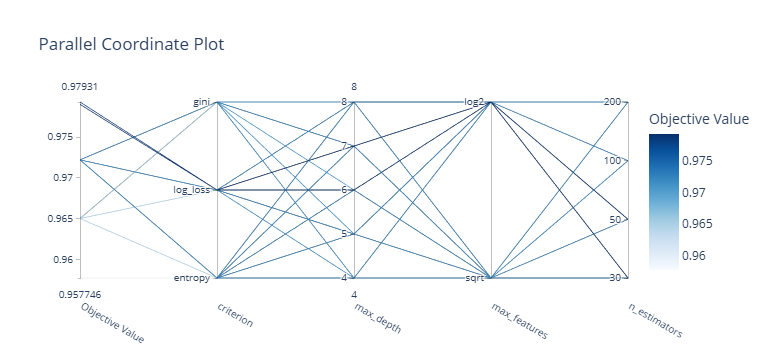

In [11]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

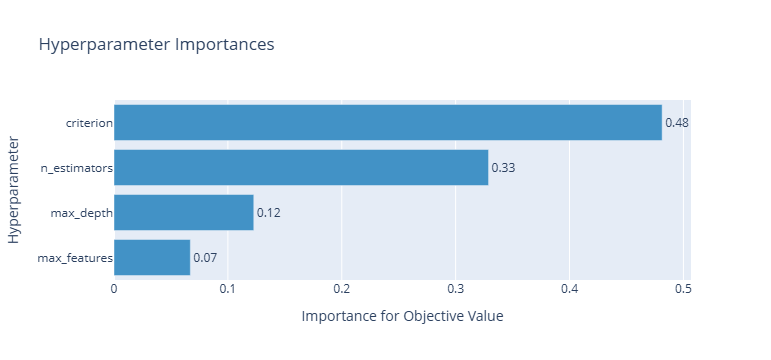

In [12]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

fig = optuna.visualization.plot_pareto_front(study)
fig.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22964\827122661.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



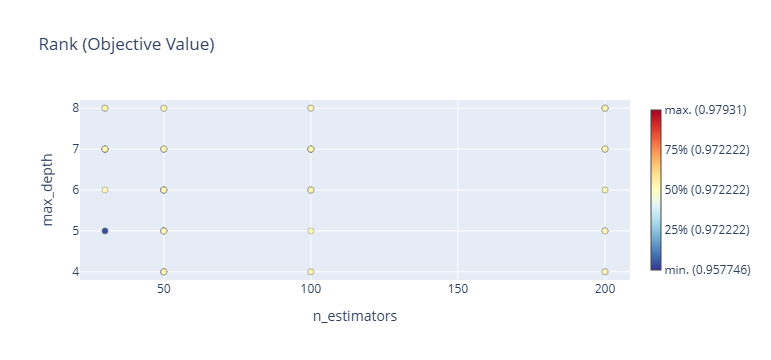

In [13]:
fig = optuna.visualization.plot_rank(study, params=['n_estimators', 'max_depth'])
fig.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22964\76922284.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



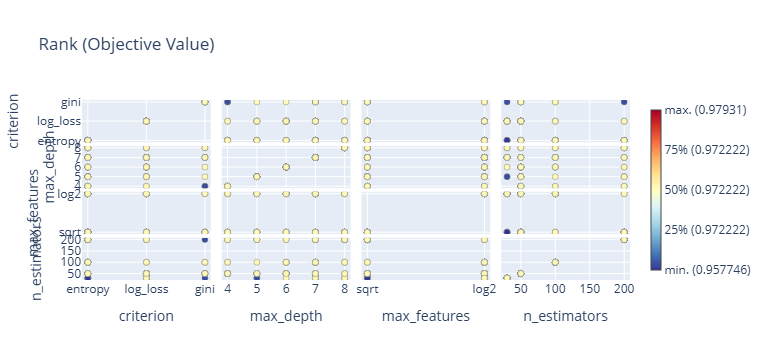

In [14]:
fig = optuna.visualization.plot_rank(study)
fig.show()

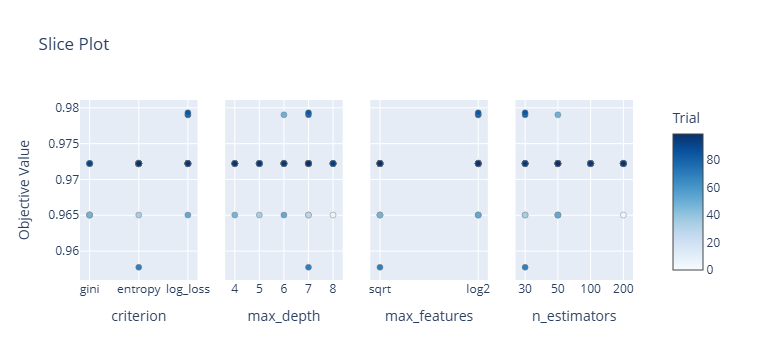

In [15]:
fig = optuna.visualization.plot_slice(study)
fig.show()

### Training

In [16]:
model = RandomForestClassifier(**study.best_params,
                               n_jobs=-1)
model.fit(X_train, y_train)

cv_results = cross_validate(model, X, y, cv=10)

In [17]:
cv_results["test_score"]

array([0.98245614, 0.9122807 , 0.94736842, 0.96491228, 0.98245614,
       0.98245614, 0.94736842, 1.        , 0.94736842, 1.        ])

### Evaluation

In [18]:
model.score(X_train, y_train)

1.0

In [19]:
model.score(X_test, y_test)

0.9649122807017544

### Confusion Matrix

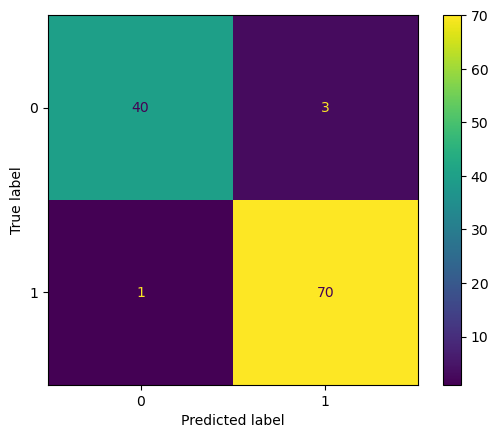

In [20]:
predictions = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions, labels=model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

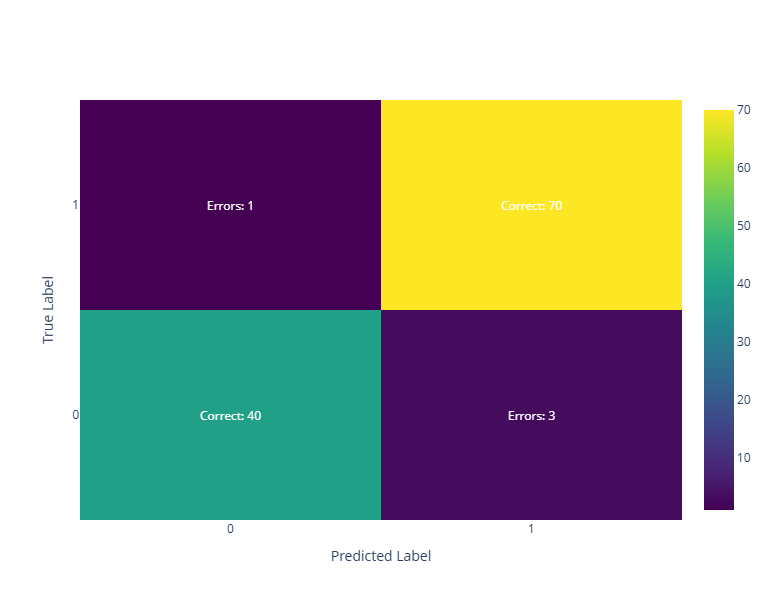

In [21]:
# Create the heatmap trace
heatmap = go.Heatmap(z=cm, x=model.classes_, y=model.classes_, colorscale='Viridis')

# Create the figure and add the heatmap trace
fig = go.Figure(data=[heatmap])

# Add annotations for each cell in the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if i == j:
            text = f"Correct: {cm[i][j]}"
        else:
            text = f"Errors: {cm[i][j]}"
        fig.add_annotation(
            text=text,
            x=model.classes_[j],
            y=model.classes_[i],
            xref='x',
            yref='y',
            showarrow=False,
            font=dict(color='white')  # Ensure text color is white for better visibility
        )

# Update axis properties
fig.update_xaxes(title_text='Predicted Label', tickmode='array', tickvals=list(range(len(model.classes_))), ticktext=model.classes_)
fig.update_yaxes(title_text='True Label', tickmode='array', tickvals=list(range(len(model.classes_))), ticktext=model.classes_)


# Set the layout to ensure the figure is square
fig.update_layout(
    width=600,  # Set the width of the figure
    height=600  # Set the height of the figure to be equal to the width
)

# Show the figure
fig.show()

### Important Features


In [22]:
model.feature_importances_

array([0.05495912, 0.01952103, 0.02973875, 0.00950287, 0.00481338,
       0.00880571, 0.06500997, 0.07783589, 0.00739921, 0.00584774,
       0.0140956 , 0.00341241, 0.01125015, 0.02647678, 0.00711503,
       0.00733564, 0.01351646, 0.00699238, 0.00614722, 0.00549105,
       0.09684267, 0.03320046, 0.14928407, 0.12125256, 0.01594471,
       0.01293406, 0.0176168 , 0.14587163, 0.01678833, 0.00499832])

In [23]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns)),
                           columns=['Value','Feature'])
feature_imp.head(10)

,Value,Feature
0,0.003412,texture error
1,0.004813,mean smoothness
2,0.004998,worst fractal dimension
3,0.005491,fractal dimension error
4,0.005848,mean fractal dimension
5,0.006147,symmetry error
6,0.006992,concave points error
7,0.007115,smoothness error
8,0.007336,compactness error
9,0.007399,mean symmetry


C:\Users\LENOVO\anaconda3\envs\ds-lasalle\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\LENOVO\anaconda3\envs\ds-lasalle\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\LENOVO\anaconda3\envs\ds-lasalle\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



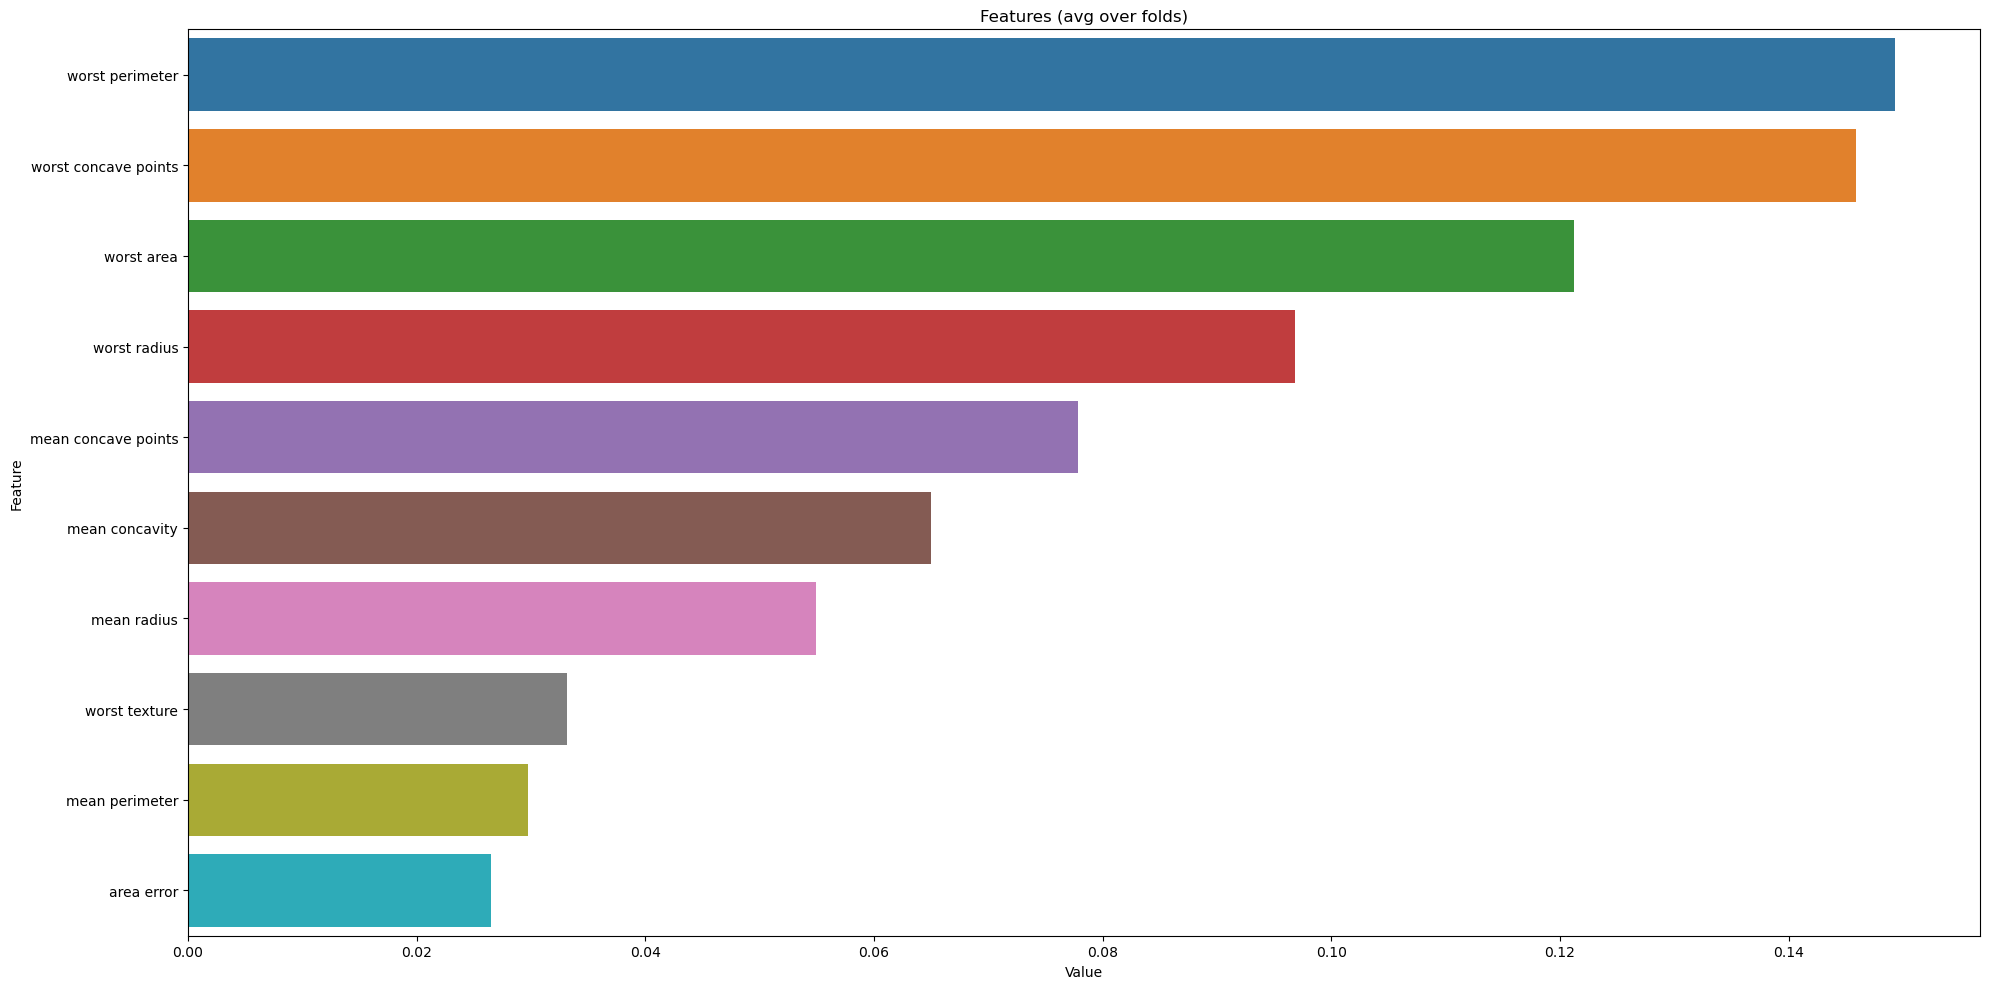

In [24]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Features (avg over folds)')
plt.tight_layout()
plt.show()

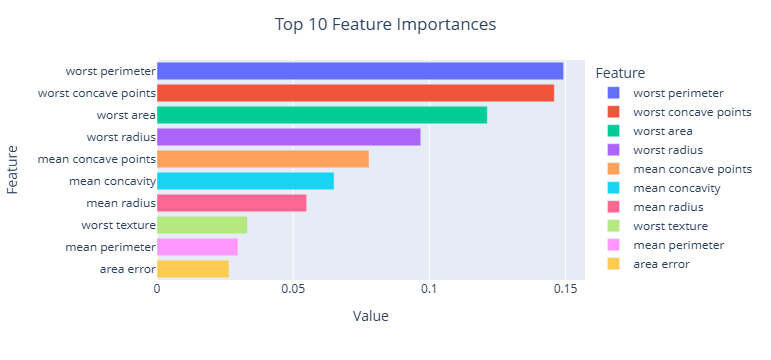

In [25]:
# Plotting the 10 more importance features

fig = px.bar(feature_imp.sort_values(by="Value", ascending=False).head(10), 
             x="Value", y="Feature", orientation="h", color="Feature")

fig.update_layout(title="Top 10 Feature Importances", title_x=0.5)
fig.show()